## Load libraries

In [5]:
library(tidyverse) #basis for data manipulation, best practices
library(edgeR) #expression normalization
library(limma) #differential expression
library(reticulate) # Load reticulate for calling the FireCloud Python API
library(bigrquery) # Load biqrquery for interacting with BigQuery
library(EnvStats)
library(xlsx)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: limma


Attaching package: ‘EnvStats’


The following objects are masked from ‘package:stats’:

    predict, predict.lm


The following object is masked from ‘package:base’:

    print.default




## Initialize Workspace Variables

In [1]:
BILLING_PROJECT_ID <- Sys.getenv('GOOGLE_PROJECT')
WORKSPACE_NAMESPACE <- Sys.getenv('WORKSPACE_NAMESPACE')
WORKSPACE_NAME <- Sys.getenv('WORKSPACE_NAME')
WORKSPACE_BUCKET <- Sys.getenv('WORKSPACE_BUCKET')

In [6]:
# Utility routine for printing a shell command before executing it
shell_do <- function(command) {
    print(paste('Executing: ', command))
    system(command, intern = TRUE)
}

In [7]:
gcs_read_file <- function(path) {
    pipe(str_glue('gsutil -u {BILLING_PROJECT_ID} cat {path}'))
}

In [8]:
#Sample metadata
samplemetaPath <- file.path({WORKSPACE_BUCKET}, 'sample_meta_white_final_PDD_PDMCI_PDNC.csv')
tmp <- gcs_read_file(samplemetaPath)
sample_meta <- read.csv(tmp,header=TRUE)

In [15]:
colnames(sample_meta)

[1] "X"                              "participant_id"                
 [3] "GUID"                           "visit_month"                   
 [5] "sample_id"                      "PCT_USABLE_BASES"              
 [7] "Plate"                          "STRAND_BALANCE"                
 [9] "diagnosis_at_baseline"          "diagnosis_latest"              
[11] "case_control_other_at_baseline" "case_control_other_latest"     
[13] "age_at_baseline"                "age_at_diagnosis"              
[15] "disease_duration"               "sex"                           
[17] "ethnicity"                      "race"                          
[19] "education_level_years"          "moca_total_score"              
[21] "Cognition_phenotype"            "age_baseline_range"

In [45]:
table(sample_meta$age_at_baseline)


19 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 
 1  2  1  2  2  5  2  1  3  3  6  4  2  6  2  9  9  9 11 10 12  9 12  9 13 16 
47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 
11 17 21 21 25 28 35 19 36 45 29 36 43 41 53 45 53 54 58 71 69 67 73 58 48 50 
73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 
43 38 35 29 30 25 24 18 20 14  3  4  1  3  3  3  1  2 

In [46]:
table(sample_meta$Cognition_phenotype)


   HCD  HCMCI HCnoCI    PDD  PDMCI PDnoCI 
     4    100    571     50    268    570 

Choose sex and age of interest

In [47]:
#this is the number of individuals who should remain in the study
sum(sample_meta$age_at_baseline >= 65 & sample_meta$sex == "Male")

[1] 456

In [48]:
sample_meta_over_65 <-sample_meta[sample_meta$age_at_baseline>=65,]

In [49]:
table(sample_meta_over_65$Cognition_phenotype)


   HCD  HCMCI HCnoCI    PDD  PDMCI PDnoCI 
     3     61    204     40    189    293 

In [50]:
table(sample_meta_over_65$age_at_baseline)


65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 
58 71 69 67 73 58 48 50 43 38 35 29 30 25 24 18 20 14  3  4  1  3  3  3  1  2 

In [51]:
sample_meta_male_over_65 <-sample_meta_over_65[sample_meta_over_65$sex=='Male',]

In [52]:
table(sample_meta_male_over_65$Cognition_phenotype)


   HCD  HCMCI HCnoCI    PDD  PDMCI PDnoCI 
     3     41     89     29    126    168 

In [53]:
table(sample_meta_male_over_65$age_at_baseline)


65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 90 
33 44 37 39 36 40 22 27 25 23 19 17 22 14 16  9 13  9  2  2  1  2  2  1  1 

In [65]:
print(str(sample_meta_male_over_65))
#notice that we obtain the 456 individuals that we expected

'data.frame':	456 obs. of  22 variables:
 $ X                             : int  7 9 11 20 28 37 38 43 44 46 ...
 $ participant_id                : chr  "BF-1009" "BF-1011" "BF-1013" "BF-1023" ...
 $ GUID                          : chr  "PDFT112PA2" "PDJP257EZP" "PDTY193MRJ" "PDRU506GJR" ...
 $ visit_month                   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sample_id                     : chr  "BF-1009-SVM0_5T1" "BF-1011-SVM0_5T1" "BF-1013-SVM0_5T1" "BF-1023-SVM0_5T1" ...
 $ PCT_USABLE_BASES              : num  0.369 0.175 0.23 0.153 0.179 ...
 $ Plate                         : chr  "P341" "P341" "P341" "P341" ...
 $ STRAND_BALANCE                : num  0.56 0.822 0.741 0.857 0.786 ...
 $ diagnosis_at_baseline         : chr  "No PD Nor Other Neurological Disorder" "Idiopathic PD" "No PD Nor Other Neurological Disorder" "No PD Nor Other Neurological Disorder" ...
 $ diagnosis_latest              : chr  "No PD Nor Other Neurological Disorder" "Idiopathic PD" "No PD Nor Other Neurological

In [66]:
sample_meta_male_over_65

,X,participant_id,GUID,visit_month,sample_id,PCT_USABLE_BASES,Plate,STRAND_BALANCE,diagnosis_at_baseline,diagnosis_latest,⋯,age_at_baseline,age_at_diagnosis,disease_duration,sex,ethnicity,race,education_level_years,moca_total_score,Cognition_phenotype,age_baseline_range
,<int>,<chr>,<chr>,<int>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>
7,7,BF-1009,PDFT112PA2,0,BF-1009-SVM0_5T1,0.368938,P341,0.559685,No PD Nor Other Neurological Disorder,No PD Nor Other Neurological Disorder,⋯,73,NA,NA,Male,Not Hispanic or Latino,White,Greater than 16 years,29,HCnoCI,above_65
8,9,BF-1011,PDJP257EZP,0,BF-1011-SVM0_5T1,0.175267,P341,0.821981,Idiopathic PD,Idiopathic PD,⋯,70,65,5,Male,Not Hispanic or Latino,White,Greater than 16 years,24,PDMCI,above_65
10,11,BF-1013,PDTY193MRJ,0,BF-1013-SVM0_5T1,0.229987,P341,0.740576,No PD Nor Other Neurological Disorder,No PD Nor Other Neurological Disorder,⋯,81,NA,NA,Male,Not Hispanic or Latino,White,Greater than 16 years,29,HCnoCI,above_65
16,20,BF-1023,PDRU506GJR,0,BF-1023-SVM0_5T1,0.153338,P341,0.857184,No PD Nor Other Neurological Disorder,No PD Nor Other Neurological Disorder,⋯,72,NA,NA,Male,Not Hispanic or Latino,White,Greater than 16 years,26,HCnoCI,above_65
24,28,BF-1032,PDJZ532TZK,0,BF-1032-SVM0_5T1,0.178567,P341,0.785834,Idiopathic PD,Idiopathic PD,⋯,70,63,7,Male,Not Hispanic or Latino,White,Greater than 16 years,18,PDD,above_65
31,37,BF-1044,PDKG534VMG,0,BF-1044-SVM0_5T1,0.543721,P342,0.518666,Idiopathic PD,Idiopathic PD,⋯,77,67,10,Male,Not Hispanic or Latino,White,Greater than 16 years,26,PDnoCI,above_65
32,38,BF-1045,PDEZ044TE4,0,BF-1045-SVM0_5T1,0.400889,P342,0.632508,Idiopathic PD,Idiopathic PD,⋯,72,72,0,Male,Not Hispanic or Latino,White,Greater than 16 years,26,PDnoCI,above_65
36,43,BF-1051,PDYA912JPR,0,BF-1051-SVM0_5T1,0.428424,P341,0.552939,Idiopathic PD,Idiopathic PD,⋯,65,59,6,Male,Not Hispanic or Latino,White,Greater than 16 years,27,PDnoCI,55_to_65
37,44,BF-1052,PDYV290XFK,0,BF-1052-SVM0_5T1,0.326003,P341,0.696349,Idiopathic PD,Idiopathic PD,⋯,66,59,7,Male,Not Hispanic or Latino,White,Greater than 16 years,24,PDMCI,above_65


In [55]:
#Transcriptomics count data
rnaPath <- file.path({WORKSPACE_BUCKET}, 'matrix.featureCounts.tsv')

In [56]:
tmp <- gcs_read_file(rnaPath)

In [57]:
countTable <- read.table(file=tmp, header=TRUE, sep="\t", check.names=FALSE, row.names="Geneid")

In [58]:
#passingGenesAnno
annoPath <- file.path({WORKSPACE_BUCKET}, 'passingGenesAnno.csv')
tmp <- gcs_read_file(annoPath)
filtGenes <- read.csv(tmp,header=TRUE)

In [59]:
dim(countTable)
head(countTable[,c(1:10)])

[1] 58780  8461

,PP-3867-SVM6T1,PD-PDMZ724XCN-SVM18T1,PP-60044-SVM24T1,PP-3604-SVM12T1,PP-3522-SVM12T1,PP-50572-SVM12T1,PD-PDCT406CN9-SVM12T1,PP-3071-SVM12T1,PP-3815-BLM0T1,PD-PDDE532JGE-SVM12T1
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
ENSG00000242268.2,1,0,3,0,1,0,1,0,0,1
ENSG00000259041.1,0,0,0,0,0,0,1,0,0,0
ENSG00000207641.1,0,0,0,0,0,0,0,0,0,0
ENSG00000270112.3,0,0,2,7,1,2,27,2,1,2
ENSG00000280143.1,6,9,38,6,27,13,18,26,19,11
ENSG00000269416.5,0,1,1,1,4,0,8,0,0,0


In [60]:
dim(filtGenes)
head(filtGenes)

[1] 2742017       8

,X,gene_id,gene_name,gene_type,seqname,start,end,strand
,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>
1,0,ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene,chr1,11869,14409,+
2,1,ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene,chr1,11869,14409,+
3,2,ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene,chr1,11869,12227,+
4,3,ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene,chr1,12613,12721,+
5,4,ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene,chr1,13221,14409,+
6,5,ENSG00000223972.5,DDX11L1,transcribed_unprocessed_pseudogene,chr1,12010,13670,+


In [61]:
countTable.back <- countTable

In [62]:
countTable <- countTable[rownames(countTable) %in% filtGenes$gene_id,]
dim(countTable)

[1] 58721  8461

In [63]:
#Subset sample data to case control only, match count table to sample table
sample_meta_male_over_65.sub <- sample_meta_male_over_65 %>%
    filter(Cognition_phenotype == "PDD" | Cognition_phenotype == "PDnoCI") %>%
    mutate(ageBin = factor(cut(age_at_baseline, breaks=c(0, 55, 65, 100),
                             labels = c("under_55", "55_to_65", "over_65"),
                             right = FALSE,
                             include.lowest = T),
                         levels = c("under_55", "55_to_65", "over_65")))

In [64]:
str(sample_meta_male_over_65.sub)

'data.frame':	197 obs. of  23 variables:
 $ X                             : int  28 37 38 43 46 57 69 72 75 83 ...
 $ participant_id                : chr  "BF-1032" "BF-1044" "BF-1045" "BF-1051" ...
 $ GUID                          : chr  "PDJZ532TZK" "PDKG534VMG" "PDEZ044TE4" "PDYA912JPR" ...
 $ visit_month                   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ sample_id                     : chr  "BF-1032-SVM0_5T1" "BF-1044-SVM0_5T1" "BF-1045-SVM0_5T1" "BF-1051-SVM0_5T1" ...
 $ PCT_USABLE_BASES              : num  0.179 0.544 0.401 0.428 0.217 ...
 $ Plate                         : chr  "P341" "P342" "P342" "P341" ...
 $ STRAND_BALANCE                : num  0.786 0.519 0.633 0.553 0.762 ...
 $ diagnosis_at_baseline         : chr  "Idiopathic PD" "Idiopathic PD" "Idiopathic PD" "Idiopathic PD" ...
 $ diagnosis_latest              : chr  "Idiopathic PD" "Idiopathic PD" "Idiopathic PD" "Idiopathic PD" ...
 $ case_control_other_at_baseline: chr  "Case" "Case" "Case" "Case" ...
 $ case_contr

In [67]:
#Here is a summary of the samples we will use for this comparison
table(sample_meta_male_over_65.sub$Cognition_phenotype, sample_meta_male_over_65.sub$sex)
table(sample_meta_male_over_65.sub$Cognition_phenotype, sample_meta_male_over_65.sub$ageBin)

        
         Male
  PDD      29
  PDnoCI  168

        
         under_55 55_to_65 over_65
  PDD           0        0      29
  PDnoCI        0        0     168

In [68]:
library(dplyr)
sample_meta_male_over_65.sub %>% filter(Cognition_phenotype == "PDD") %>% pull(age_at_baseline) %>% mean()
sample_meta_male_over_65.sub %>% filter(Cognition_phenotype == "PDD") %>% pull(age_at_baseline) %>% sd()
sample_meta_male_over_65.sub %>% filter(Cognition_phenotype == "PDnoCI") %>% pull(age_at_baseline) %>% mean()
sample_meta_male_over_65.sub %>% filter(Cognition_phenotype == "PDnoCI") %>% pull(age_at_baseline) %>% sd()

[1] 74.24138

[1] 6.197091

[1] 70.29762

[1] 4.440639

In [69]:
#order count table and metadata table to match
countsSub <- countTable[,names(countTable) %in% sort(sample_meta_male_over_65.sub$sample_id)]
dim(countsSub)

[1] 58721   197

In [70]:
i <- match(sample_meta_male_over_65.sub$sample_id, names(countsSub), nomatch = 0)
countsSub <- countsSub[,i]

In [71]:
identical(names(countsSub), sample_meta_male_over_65.sub$sample_id) #double checking

[1] TRUE

Differential Expression testing with limma

In [72]:
## sample design
case <- factor(gsub("\\+", "", sample_meta_male_over_65.sub$Cognition_phenotype), levels = c("PDD", "PDnoCI"))
age <- factor(sample_meta_male_over_65.sub$ageBin, levels = c("under_55", "55_to_65", "over_65"))
sex <- factor(sample_meta_male_over_65.sub$sex,
              levels = c("Male", "Female"))
plate <- factor(sample_meta_male_over_65.sub$Plate)
usableBases <- sample_meta_male_over_65.sub$PCT_USABLE_BASES
strandBalance <- sample_meta_male_over_65.sub$STRAND_BALANCE

In [119]:
design <- model.matrix(~ 0 + case + plate  + usableBases + strandBalance)

In [120]:
design

,casePDD,casePDnoCI,plateP202,plateP203,plateP205,plateP206,plateP207,plateP208,plateP209,plateP210,⋯,plateP336,plateP337,plateP338,plateP339,plateP340,plateP341,plateP342,plateP343,usableBases,strandBalance
1,1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,1,0,0,0.178567,0.785834
2,0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0.543721,0.518666
3,0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0.400889,0.632508
4,0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,1,0,0,0.428424,0.552939
5,0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,1,0,0,0.217465,0.761710
6,0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,1,0,0,0.204843,0.805482
7,0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0.303373,0.591517
8,0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0.267975,0.702552
9,0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0.297992,0.594147
10,0,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,1,0,0.346323,0.679662


In [121]:
colnames(design) <- gsub("case", "", colnames(design))

In [122]:
contr.matrix <- makeContrasts(
  Case_vs_Control = PDD - PDnoCI,
  levels = colnames(design)
)

In [123]:
contr.matrix

,Case_vs_Control
PDD,1
PDnoCI,-1
plateP202,0
plateP203,0
plateP205,0
plateP206,0
plateP207,0
plateP208,0
plateP209,0
plateP210,0


Pre-filtering and count normalization to counts per million (CPM)

In [124]:
## normalization and filtering in limma
keep <- filterByExpr(countsSub, group = case)
sum(keep) #this is the number of genes we are testing for differential expression

[1] 23493

In [125]:
dge <- DGEList(countsSub[keep,])

In [126]:
dge  <- calcNormFactors(dge) #normalizes, what does it do?

In [127]:
#sample_meta_male_over_65.sub$sex <- as.factor(sample_meta_male_over_65.sub$sex)

In [128]:
#par(mfrow=c(1,2))
#levels(sample_meta_male_over_65.sub$sex) #what is this?
#col.cell <- c("purple","orange")[sample_meta_male_over_65.sub$sex]
#data.frame(sample_meta_male_over_65.sub$sex,col.cell)

In [129]:
#plotMDS(dge,col=col.cell)

In [130]:
#order gene list
genes.anno.Match <- filtGenes[filtGenes$gene_id %in% sort(row.names(dge$counts)),]
dim(genes.anno.Match)

[1] 2339889       8

In [131]:
i <- match(row.names(dge$counts), genes.anno.Match$gene_id, nomatch = 0)

In [132]:
genes.anno.Match <- genes.anno.Match[i,]

In [133]:
genes.anno.Match

,X,gene_id,gene_name,gene_type,seqname,start,end,strand
,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>
1553274,1553273,ENSG00000280143.1,AP000892.3,TEC,chr11,117204967,117210292,+
653470,653469,ENSG00000263642.1,MIR4802,miRNA,chr4,40502040,40502119,-
2018910,2018909,ENSG00000158486.13,DNAH3,protein_coding,chr16,20933111,21159441,-
2157821,2157820,ENSG00000198242.13,RPL23A,protein_coding,chr17,28719393,28724359,+
1767755,1767754,ENSG00000231981.3,RPL7L1P12,processed_pseudogene,chr13,98949719,98950447,-
458779,458778,ENSG00000134108.12,ARL8B,protein_coding,chr3,5122220,5180912,+
1759388,1759387,ENSG00000276644.4,DACH1,protein_coding,chr13,71437966,71867192,-
33611,33610,ENSG00000231105.1,AL031728.1,antisense,chr1,21293290,21299774,+
2430783,2430782,ENSG00000167578.17,RAB4B,protein_coding,chr19,40778216,40796938,+


In [87]:
identical(genes.anno.Match$gene_id, row.names(dge$counts)) #double checking

[1] TRUE

In [88]:
dge$genes <- genes.anno.Match

In [89]:
dim(dge) #where rows are the samples

[1] 23493   197

In [134]:
CPM <- cpm(dge) #used to calculate counts per million (CPM) values for a matrix or data frame of
#normalized counts. CPM values are commonly used to normalize and compare gene expression levels across different samples.

In [135]:
logCPM <- cpm(dge, log = TRUE, prior.count = 3)

In [136]:
cpm_names <- cbind(gene_name=genes.anno.Match$gene_name, CPM) #it was binded the gene name from gene anno and the cpm matrix from
#the count_table matrix. 
head(cpm_names)[1:5,1:5] #when CPM ==0?

,gene_name,BF-1032-SVM0_5T1,BF-1044-SVM0_5T1,BF-1045-SVM0_5T1,BF-1051-SVM0_5T1
ENSG00000280143.1,AP000892.3,0.202363877216088,0.177996774242548,0.101737260150988,0.342571191453697
ENSG00000263642.1,MIR4802,1.8212748949448,0.45770599090941,0.813898081207903,0.570951985756162
ENSG00000158486.13,DNAH3,0,0.0762843318182351,0,0
ENSG00000198242.13,RPL23A,346.514412419682,634.100794183776,486.609315302175,498.288829702261
ENSG00000231981.3,RPL7L1P12,1.21418326329653,0.559418433333724,0.356080410528458,1.06577704007817


In [137]:
dim(cpm_names) #just one column more: gene_name

[1] 23493   198

In [138]:
cpm_names_dist <- distinct(as.data.frame(cpm_names), gene_name, .keep_all = TRUE)
head(cpm_names_dist)[1:5,1:5]
dim(cpm_names)
dim(cpm_names_dist)

,gene_name,BF-1032-SVM0_5T1,BF-1044-SVM0_5T1,BF-1045-SVM0_5T1,BF-1051-SVM0_5T1
,<chr>,<chr>,<chr>,<chr>,<chr>
ENSG00000280143.1,AP000892.3,0.202363877216088,0.177996774242548,0.101737260150988,0.342571191453697
ENSG00000263642.1,MIR4802,1.8212748949448,0.45770599090941,0.813898081207903,0.570951985756162
ENSG00000158486.13,DNAH3,0,0.0762843318182351,0,0
ENSG00000198242.13,RPL23A,346.514412419682,634.100794183776,486.609315302175,498.288829702261
ENSG00000231981.3,RPL7L1P12,1.21418326329653,0.559418433333724,0.356080410528458,1.06577704007817


[1] 23493   198

[1] 23314   198

Limma voom, fit, and eBayes

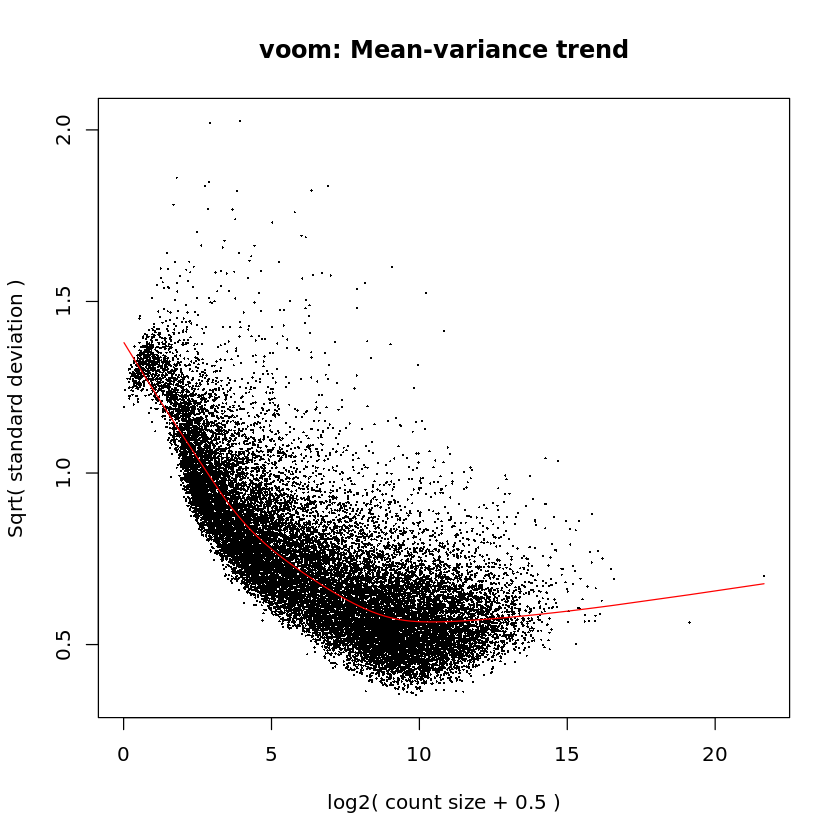

In [139]:
#Transform count data to log2-counts per million (logCPM), estimate the mean-variance relationship and use this to compute appropriate observational-level weights.
#The data are then ready for linear modelling.
v <- voom(dge, design, plot=TRUE) #check voom plot for curve to see if we need to do more filtering
# voom is used to transform RNA-seq count data into log-counts-per-million (logCPM) values suitable for linear modeling and differential expression analysis.

#design: A design matrix or model matrix specifying the experimental design and contrasts of interest for differential expression analysis.

In [140]:
#compute linear model fit for each gene, given our design and the results from voom
vfit <- lmFit(v, design)
vfit.con1 <- contrasts.fit(vfit, contrasts=contr.matrix) 
#The lmFit() function is a part of the limma package in R.
#It is used for fitting linear models to gene expression data, particularly for 
#differential expression analysis in microarray and RNA-seq experiments.

The eBayes() function applies an empirical Bayes method to estimate the overall distribution of gene-specific variances. It shrinks the estimated gene-specific variances towards a common value, resulting in more stable and moderated estimates. This shrinkage improves the accuracy of statistical inference, especially in cases where the number of samples is small.

In [142]:
#Given a linear model fit, compute moderated t-statistics, moderated F-statistic, and log-odds of differential expression by empirical Bayes moderation of the standard errors towards a common value
efit <- eBayes(vfit.con1)

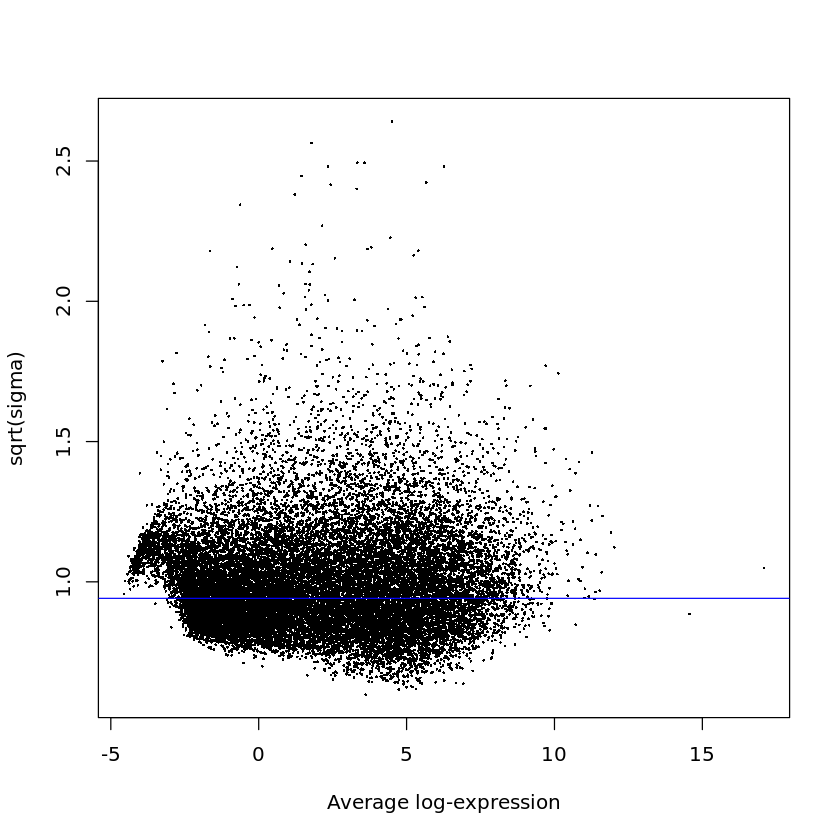

In [143]:
plotSA(efit)

In [144]:
#summary of differential expression results
summary(decideTests(efit))

       Case_vs_Control
Down                 0
NotSig           23493
Up                   0

In [145]:
DE.results <- as.data.frame(summary(decideTests(efit))) %>%
pivot_wider(names_from = Var2, values_from = Freq)

In [146]:
DE.results

Var1,Case_vs_Control
<fct>,<dbl>
Down,0
NotSig,23493
Up,0


In [147]:
#make table of mean CPM for each group to add to results file
control.Group <- sample_meta_male_over_65.sub$sample_id[sample_meta_male_over_65.sub$Cognition_phenotype == "PDnoCI"]
case.Group <- sample_meta_male_over_65.sub$sample_id[sample_meta_male_over_65.sub$Cognition_phenotype == "PDD"]

In [148]:
controlCPM <- logCPM[,control.Group]
caseCPM <- logCPM[,case.Group]

In [149]:
meanCPM <- data.frame("gene_id" = row.names(logCPM),
                      "AvgExpr_Control" = rowMeans(controlCPM),
                      "AvgExpr_Case" = rowMeans(caseCPM)

)
summary(meanCPM)

   gene_id          AvgExpr_Control    AvgExpr_Case    
 Length:23493       Min.   :-2.6896   Min.   :-2.5120  
 Class :character   1st Qu.:-0.4647   1st Qu.:-0.2343  
 Mode  :character   Median : 2.0154   Median : 2.0619  
                    Mean   : 2.2389   Mean   : 2.3153  
                    3rd Qu.: 4.6562   3rd Qu.: 4.5320  
                    Max.   :17.1560   Max.   :16.6679  

In [150]:
head(meanCPM)

,gene_id,AvgExpr_Control,AvgExpr_Case
,<chr>,<dbl>,<dbl>
ENSG00000280143.1,ENSG00000280143.1,-1.1418424,-0.6193143
ENSG00000263642.1,ENSG00000263642.1,0.1054059,0.3480949
ENSG00000158486.13,ENSG00000158486.13,-2.0829105,-0.9708706
ENSG00000198242.13,ENSG00000198242.13,8.6433642,8.1442674
ENSG00000231981.3,ENSG00000231981.3,0.3029934,0.2518915
ENSG00000134108.12,ENSG00000134108.12,5.8110152,5.5225695


In [151]:
#Classify a series of related t-statistics as up, down or not significant
dt <- decideTests(efit)

In [152]:
#output full results table with logFC, p values, and mean CPM for each gene
df <- topTable(efit, coef = 1, n = Inf)

In [153]:
df.withMeans <- left_join(df, meanCPM)

ERROR: [1m[33mError[39m in `left_join()`:[22m
[1m[22m[33m![39m `by` must be supplied when `x` and `y` have no common variables.
[36mℹ[39m Use `cross_join()` to perform a cross-join.


In [154]:
df.withMeans$minus_log10_pValue <- -log10(df.withMeans$P.Value)

In [155]:
head(df.withMeans)

,X,gene_id,gene_name,gene_type,seqname,start,end,strand,logFC,AveExpr,t,P.Value,adj.P.Val,B,AvgExpr_Control,AvgExpr_Case,minus_log10_pValue
,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1047081,ENSG00000127990.17,SGCE,protein_coding,chr7,94524204,94656572,-,0.9575136,0.89401577,4.333610,2.839283e-05,0.1132687,2.113137,0.8762440,1.5804330,4.546791
2,2170746,ENSG00000277089.4,AC243829.4,antisense,chr17,36072866,36090134,+,0.9573735,0.42217805,4.340574,2.761464e-05,0.1132687,1.903950,0.4425883,1.0641576,4.558861
3,615568,ENSG00000163923.9,RPL39L,protein_coding,chr3,187120948,187180908,-,0.6228526,0.03437278,4.349092,2.669058e-05,0.1132687,1.884240,0.1107291,0.4942215,4.573642
4,1675713,ENSG00000180881.19,CAPS2,protein_coding,chr12,75275979,75390928,-,0.4369203,2.87292816,4.218148,4.481451e-05,0.1132687,1.875624,2.8651820,3.0439512,4.348581
5,1683400,ENSG00000258302.2,AC025034.1,antisense,chr12,89561129,89594878,+,0.5329528,0.70404143,4.238647,4.135171e-05,0.1132687,1.753780,0.7476157,1.0186976,4.383507
6,1872776,ENSG00000211973.2,IGHV1-69,IG_V_gene,chr14,106714684,106715181,-,-1.8540707,-1.88502352,-4.579615,1.044862e-05,0.1132687,1.728243,-1.1272713,-1.9601323,4.980941


In [156]:
library(ggrepel)

In [157]:
genes<-subset(df.withMeans,((adj.P.Val<0.05 & logFC>=log2(1.5)) | (adj.P.Val<0.05 & logFC<=-log2(1.5))))

In [158]:
genes

X,gene_id,gene_name,gene_type,seqname,start,end,strand,logFC,AveExpr,t,P.Value,adj.P.Val,B,AvgExpr_Control,AvgExpr_Case,minus_log10_pValue
<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [159]:
df <- df %>% 
  mutate(
    Expression = case_when(logFC >= log2(1.5) & adj.P.Val <= 0.05 ~ "Up-regulated",
                           logFC <= -log2(1.5) & adj.P.Val <= 0.05 ~ "Down-regulated",
                           TRUE ~ "Unchanged")
    )

In [160]:
p2 <- ggplot(df, aes(logFC, -log(adj.P.Val,10))) +
  geom_point(aes(color = Expression), size = 1) +
  xlab(expression("log"[2]*"FC")) + 
  ylab(expression("-log"[10]*"(padj)")) +
  scale_color_manual(values = c("dodgerblue3", "gray50", "firebrick3")) +
  guides(colour = guide_legend(override.aes = list(size=1.5)))+
  geom_hline(yintercept = -log10(0.05),linetype = "dashed") + 
  geom_vline(xintercept = c(-log2(1.5), log2(1.5)),linetype = "dashed") +
  geom_text_repel(data = genes, 
                  aes(label = gene_name))

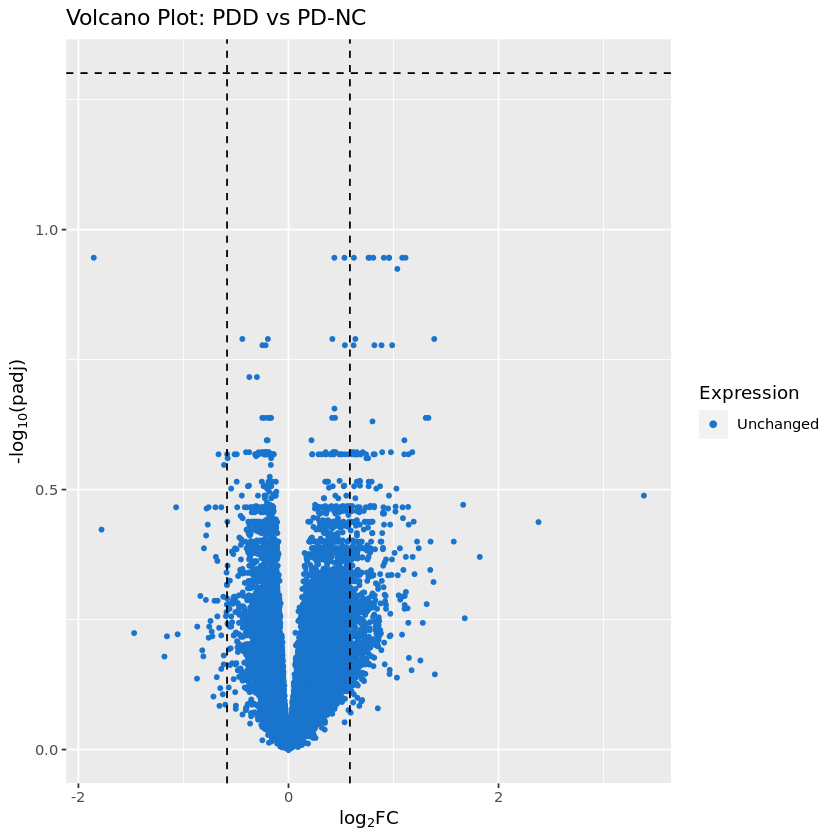

In [161]:
p2 + ggtitle("Volcano Plot: PDD vs PD-NC")
#linea horizontal log fold change
#linea vertical -log10 p value

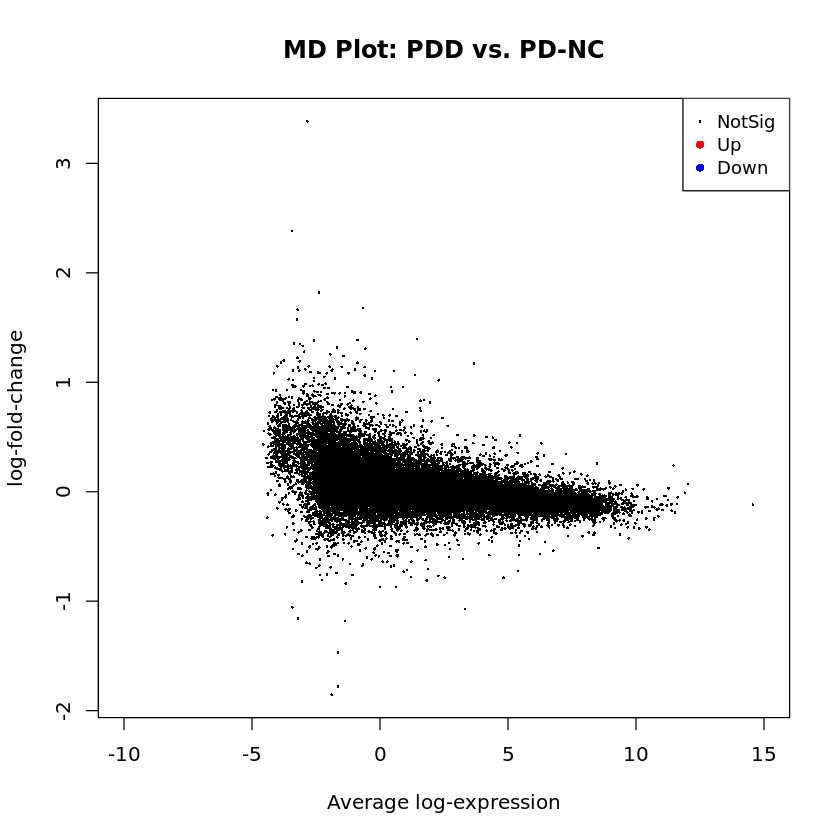

In [162]:
#MD plot with upregulated genes in green and downregulated genes in red
plotMD(efit, column = 1, status = dt[,1], main = "MD Plot: PDD vs. PD-NC",
       xlim=c(-10,15))

In [163]:
write_tsv(df.withMeans, "PDD_vs_PDnoCI_M0_passingFilt_white_limmaResults.tsv")

In [164]:
system(paste0("gsutil cp ./* ",WORKSPACE_BUCKET),intern=TRUE)

character(0)

In [165]:
#df.withMeans
df.withMeansPath <- file.path({WORKSPACE_BUCKET}, 'PDD_vs_PDnoCI_M0_passingFilt_white_limmaResults.tsv')
tmp <- gcs_read_file(df.withMeansPath)
df.withMeans <- read.csv(tmp,header=TRUE, sep="\t")

In [166]:
df.withMeans

X,gene_id,gene_name,gene_type,seqname,start,end,strand,logFC,AveExpr,t,P.Value,adj.P.Val,B,AvgExpr_Control,AvgExpr_Case,minus_log10_pValue
<int>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1047081,ENSG00000127990.17,SGCE,protein_coding,chr7,94524204,94656572,-,0.9575136,0.8940157735,4.333610,2.839283e-05,0.1132687,2.11313738,0.87624398,1.58043298,4.546791
2170746,ENSG00000277089.4,AC243829.4,antisense,chr17,36072866,36090134,+,0.9573735,0.4221780501,4.340574,2.761464e-05,0.1132687,1.90394999,0.44258832,1.06415763,4.558861
615568,ENSG00000163923.9,RPL39L,protein_coding,chr3,187120948,187180908,-,0.6228526,0.0343727768,4.349092,2.669058e-05,0.1132687,1.88424027,0.11072914,0.49422146,4.573642
1675713,ENSG00000180881.19,CAPS2,protein_coding,chr12,75275979,75390928,-,0.4369203,2.8729281601,4.218148,4.481451e-05,0.1132687,1.87562447,2.86518204,3.04395116,4.348581
1683400,ENSG00000258302.2,AC025034.1,antisense,chr12,89561129,89594878,+,0.5329528,0.7040414301,4.238647,4.135171e-05,0.1132687,1.75377966,0.74761571,1.01869761,4.383507
1872776,ENSG00000211973.2,IGHV1-69,IG_V_gene,chr14,106714684,106715181,-,-1.8540707,-1.8850235174,-4.579615,1.044862e-05,0.1132687,1.72824274,-1.12727131,-1.96013234,4.980941
2347526,ENSG00000125726.10,CD70,protein_coding,chr19,6583183,6604103,-,0.8076482,-0.1433975112,4.300069,3.244593e-05,0.1132687,1.63119350,-0.06406166,0.45302989,4.488840
1859608,ENSG00000168350.7,DEGS2,protein_coding,chr14,100143957,100160163,-,0.9076694,-0.7508862081,4.197713,4.854232e-05,0.1132687,1.31069173,-0.61884449,0.32111462,4.313879
794644,ENSG00000197744.5,PTMAP2,processed_pseudogene,chr5,118973796,118974122,+,0.7619128,-1.1307252500,4.262738,3.760982e-05,0.1132687,1.16169876,-0.85659052,-0.65665827,4.424699


In [167]:
genes<-subset(df.withMeans,((adj.P.Val<=0.05 & logFC>=log2(1.5)) | (adj.P.Val<=0.05 & logFC<=-log2(1.5))),select="gene_name")
genes

gene_name
<chr>


In [168]:
library(goseq)
library(org.Hs.eg.db)
library(GO.db)

Loading required package: BiasedUrn

Loading required package: geneLenDataBase



Loading required package: AnnotationDbi

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:limma’:

    plotMA


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique,

In [169]:
genes<-subset(df.withMeans,((adj.P.Val<=0.05 & logFC>=log2(1.5)) | (adj.P.Val<=0.05 & logFC<=-log2(1.5))),select="gene_id")
genes$gene_id <- sub("\\..*", "", genes$gene_id)
genes<-genes$gene_id

In [170]:
genes

character(0)

In [171]:
library(clusterProfiler)
library(ggplot2)

clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProfiler in published research, please cite:
T Wu, E Hu, S Xu, M Chen, P Guo, Z Dai, T Feng, L Zhou, W Tang, L Zhan, X Fu, S Liu, X Bo, and G Yu. clusterProfiler 4.0: A universal enrichment tool for interpreting omics data. The Innovation. 2021, 2(3):100141


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:AnnotationDbi’:

    select


The following object is masked from ‘package:IRanges’:

    slice


The following object is masked from ‘package:S4Vectors’:

    rename


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:stats’:

    filter




In [172]:
sample_test <- enrichGO(genes, OrgDb=org.Hs.eg.db, pAdjustMethod = "BH", pvalueCutoff  = 0.01, qvalueCutoff  = 0.05,keyType = "ENSEMBL",ont="BP")

--> No gene can be mapped....

--> Expected input gene ID: ENSG00000125779,ENSG00000185728,ENSG00000143452,ENSG00000215021,ENSG00000180509,ENSG00000101574

--> return NULL...



ont= MP (molecular process), BP (biological process), MF (molecular function, in what process is involved?)

In [ ]:
sample_test

In [ ]:
enrich_go_tidy <- sample_test %>% 
  slot("result") %>% 
  tibble::as.tibble() 
enrich_go_tidy

In [ ]:
dotplot(sample_test,font.size = 8)

In [ ]:
library(enrichplot)

In [ ]:
par(mfrow=c(5,5))
goplot(sample_test,font.size=5)